In [ ]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ta.momentum import RSIIndicator
from ta.trend import MACD
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import os
import warnings
warnings.filterwarnings("ignore")

In [17]:
symbols = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS"]

In [18]:
for symbol in symbols:   
    stock = yf.Ticker(symbol)
    info = stock.info
    print(f"Symbol: {symbol}")
    print(f"Name: {info.get('shortName', 'N/A')}")
    print(f"Market: {info.get('market', 'N/A')}")
    print(f"Sector: {info.get('sector', 'N/A')}")
    print("-" * 30)

Symbol: RELIANCE.NS
Name: RELIANCE INDUSTRIES LTD
Market: in_market
Sector: Energy
------------------------------
Symbol: HDFCBANK.NS
Name: HDFC BANK LTD
Market: in_market
Sector: Financial Services
------------------------------
Symbol: INFY.NS
Name: INFOSYS LIMITED
Market: in_market
Sector: Technology
------------------------------


# DATA VISUALISATION


Historical Data for HDFCBANK.NS for the last 6 months:
+---------------------------+---------+---------+---------+---------+-------------+-------------+----------------+
| Date                      |    Open |    High |     Low |   Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+---------+---------+---------+---------+-------------+-------------+----------------|
| 2025-02-01 00:00:00+05:30 | 1679.03 | 1694.36 | 1657.81 | 1672.55 | 2.79376e+06 |           0 |              0 |
| 2025-02-03 00:00:00+05:30 | 1651.83 | 1668.45 | 1645.35 | 1659.74 | 1.01383e+07 |           0 |              0 |
| 2025-02-04 00:00:00+05:30 | 1670.32 | 1707.02 | 1661.77 | 1702.17 | 1.43083e+07 |           0 |              0 |
| 2025-02-05 00:00:00+05:30 | 1714.14 | 1725.22 | 1700.2  | 1718.89 | 1.18378e+07 |           0 |              0 |
| 2025-02-06 00:00:00+05:30 | 1716.62 | 1729.97 | 1705.24 | 1724.87 | 1.33804e+07 |           0 |              0 |
| 2025-07-28 00:00:00+05:

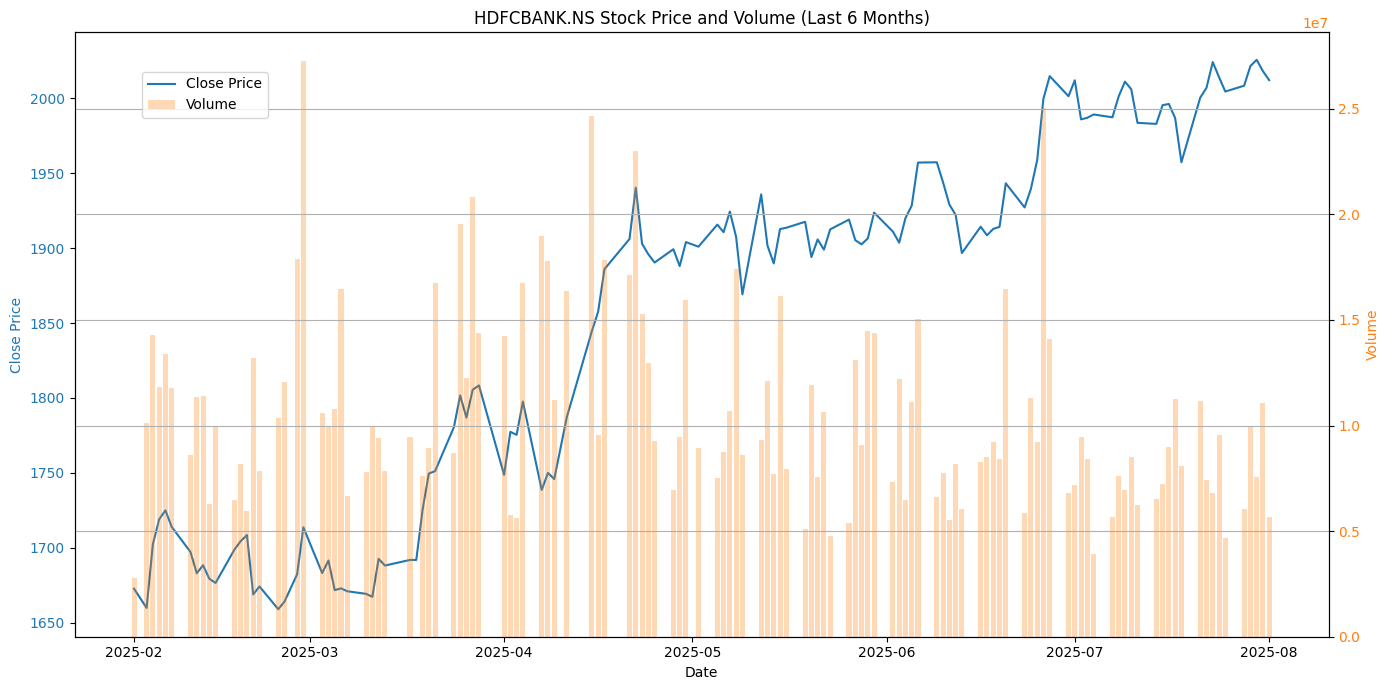

In [26]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'HDFCBANK.NS'
period = '6mo'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

Historical Data for RELIANCE.NS for the last 6 months:
+---------------------------+---------+---------+---------+---------+-------------+-------------+----------------+
| Date                      |    Open |    High |     Low |   Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+---------+---------+---------+---------+-------------+-------------+----------------|
| 2025-02-01 00:00:00+05:30 | 1265.1  | 1270.55 | 1241    | 1264.6  | 7.11845e+06 |           0 |              0 |
| 2025-02-03 00:00:00+05:30 | 1251    | 1256    | 1237.55 | 1245.9  | 9.25234e+06 |           0 |              0 |
| 2025-02-04 00:00:00+05:30 | 1248.05 | 1288.8  | 1246.6  | 1285.2  | 1.66911e+07 |           0 |              0 |
| 2025-02-05 00:00:00+05:30 | 1282.65 | 1290.5  | 1276.7  | 1278.2  | 1.0112e+07  |           0 |              0 |
| 2025-02-06 00:00:00+05:30 | 1273.7  | 1288    | 1270.35 | 1281.55 | 9.956e+06   |           0 |              0 |
| 2025-07-28 00:00:00+05:

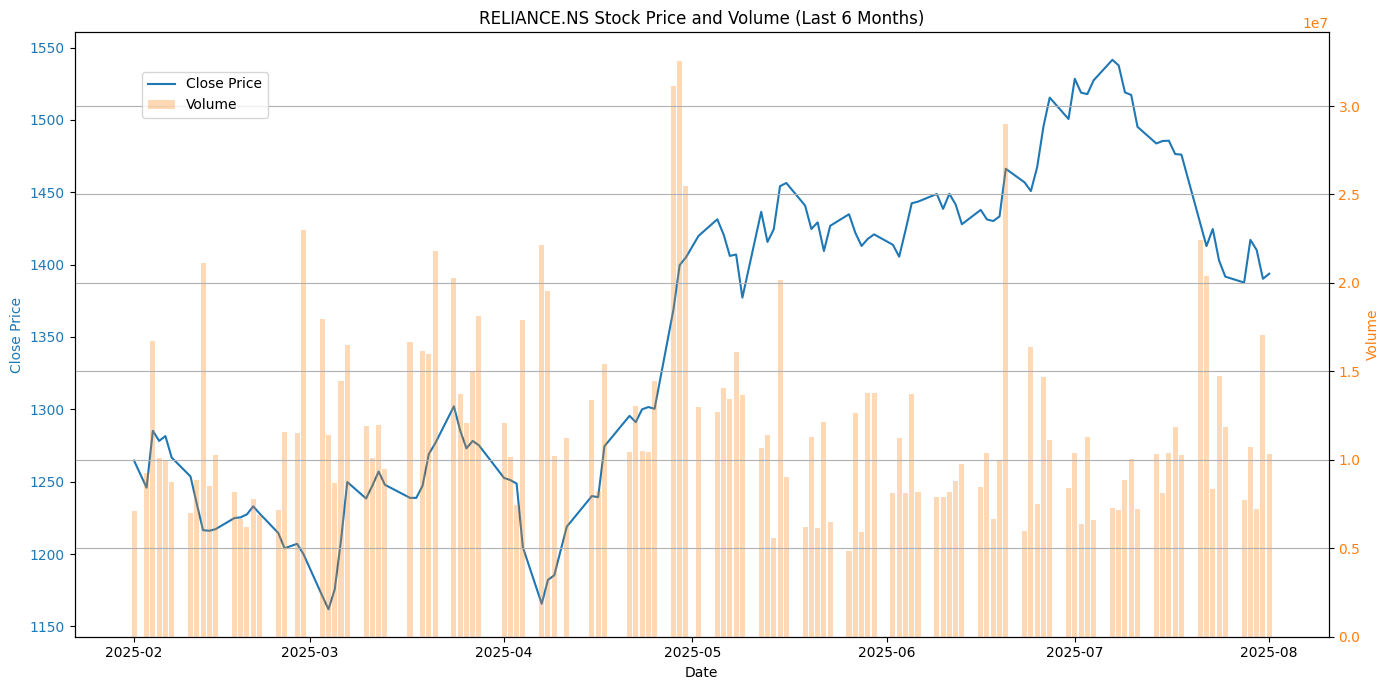

In [27]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'RELIANCE.NS'
period = '6mo'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

Historical Data for INFY.NS for the last 6 months:
+---------------------------+---------+---------+---------+---------+-------------+-------------+----------------+
| Date                      |    Open |    High |     Low |   Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+---------+---------+---------+---------+-------------+-------------+----------------|
| 2025-02-01 00:00:00+05:30 | 1854.21 | 1864.37 | 1820.39 | 1825.66 | 1.7014e+06  |           0 |              0 |
| 2025-02-03 00:00:00+05:30 | 1810.53 | 1850.51 | 1806.98 | 1837.45 | 4.82323e+06 |           0 |              0 |
| 2025-02-04 00:00:00+05:30 | 1862.79 | 1884.68 | 1848.98 | 1872.45 | 7.33479e+06 |           0 |              0 |
| 2025-02-05 00:00:00+05:30 | 1879.55 | 1893.06 | 1868.02 | 1870.73 | 4.99674e+06 |           0 |              0 |
| 2025-02-06 00:00:00+05:30 | 1890.4  | 1897.3  | 1873.64 | 1889.07 | 4.76526e+06 |           0 |              0 |
| 2025-07-28 00:00:00+05:30 |

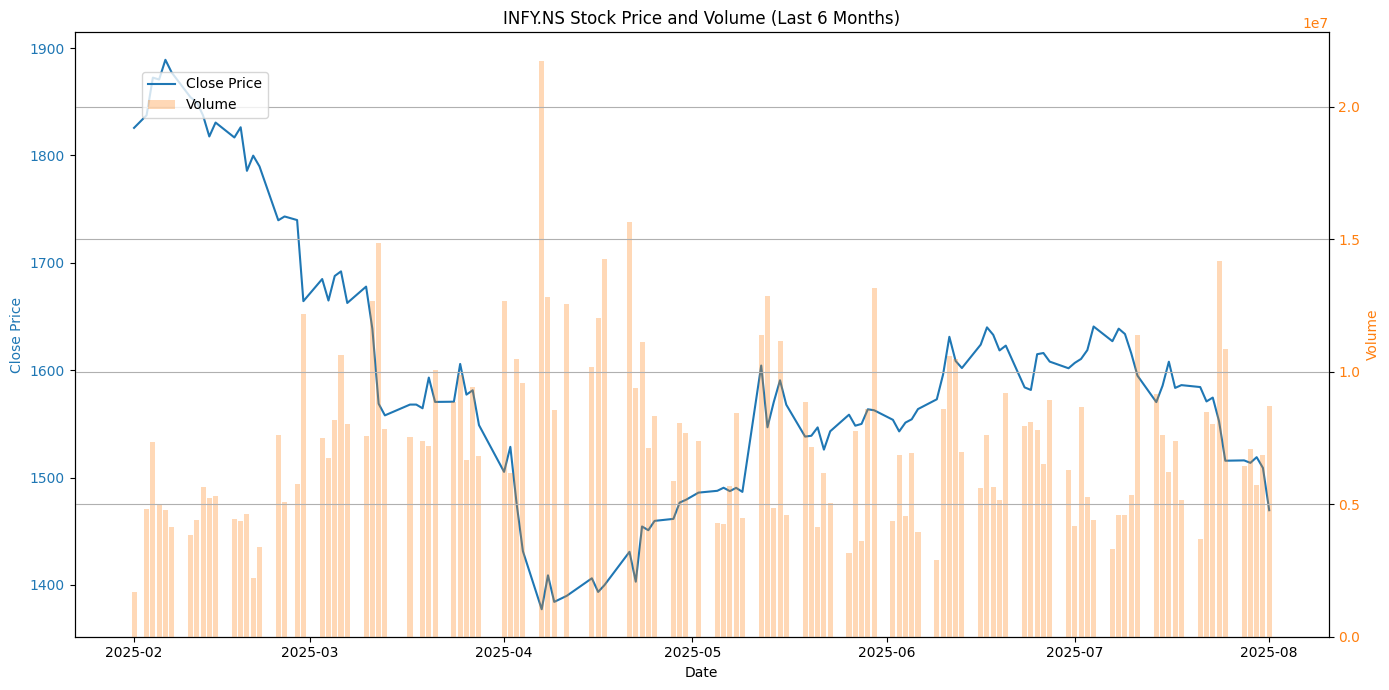

In [28]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'INFY.NS'
period = '6mo'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

# PREPROCESSING THE DATA

In [30]:
from ta.momentum import RSIIndicator
from ta.trend import MACD

def preprocess_stock(df):
    df = df.copy()  

    df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int) 
    #Here the output is 1 if the next day's close price is greater than today's close price, else 0

    df["RSI"] = RSIIndicator(df["Close"], window=14).rsi()  #first trading strategy

    macd = MACD(df["Close"])    # second trading strategy
    df["MACD"] = macd.macd()
    df["MACD_Signal"] = macd.macd_signal()

    df["SMA_20"] = df["Close"].rolling(window=20).mean()
    df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()

    df["Volatility"] = df["Close"].rolling(window=10).std()

    df = df.dropna()

    return df

In [51]:
symbol_infy = 'INFY.NS'
print(f"Preprocessed data for {symbol_infy}")
data_infy = yf.Ticker(symbol_infy).history(period='6mo')
processed_infy = preprocess_stock(data_infy)
processed_infy.head()


Preprocessed data for INFY.NS


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Target,RSI,MACD,MACD_Signal,SMA_20,EMA_20,Volatility
Date,,,,,,,,,,,,,,
2025-03-21 00:00:00+05:30,1556.056090,1581.646109,1541.954573,1570.453613,10074677,0.0,0.0,1,28.932108,-61.146810,-57.513503,1658.795569,1649.976443,45.148754
2025-03-24 00:00:00+05:30,1575.778559,1584.801628,1550.878900,1570.650757,8857726,0.0,0.0,1,28.987918,-59.889623,-57.988727,1647.336792,1642.421616,39.280318
2025-03-25 00:00:00+05:30,1582.730762,1613.448582,1582.730762,1605.855347,9890140,0.0,0.0,0,38.305117,-55.413801,-57.473742,1638.138708,1638.939114,24.909639
2025-03-26 00:00:00+05:30,1603.439483,1615.026454,1572.869604,1577.257812,6651302,0.0,0.0,1,34.361137,-53.556891,-56.690371,1630.020435,1633.064704,14.378132
2025-03-27 00:00:00+05:30,1573.412024,1597.473381,1563.994481,1581.301025,9426573,0.0,0.0,0,35.374269,-51.169177,-55.586133,1621.926819,1628.134830,14.373838


In [52]:
symbol_reliance = 'RELIANCE.NS'
print(f"Preprocessed data for {symbol_reliance}")
data_reliance = yf.Ticker(symbol_reliance).history(period='6mo')
processed_reliance = preprocess_stock(data_reliance)
processed_reliance.head()

Preprocessed data for RELIANCE.NS


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Target,RSI,MACD,MACD_Signal,SMA_20,EMA_20,Volatility
Date,,,,,,,,,,,,,,
2025-03-21 00:00:00+05:30,1275.000000,1281.000000,1270.099976,1276.349976,21780769,0.0,0.0,1,63.340584,7.019228,0.097185,1225.802509,1238.828981,12.919197
2025-03-24 00:00:00+05:30,1291.000000,1306.000000,1284.250000,1302.099976,20299319,0.0,0.0,0,68.901369,11.058691,2.289487,1229.257507,1244.854790,20.629053
2025-03-25 00:00:00+05:30,1307.699951,1307.699951,1282.599976,1285.449951,13713899,0.0,0.0,0,62.318847,12.769281,4.385446,1232.122504,1248.720996,21.439889
2025-03-26 00:00:00+05:30,1291.000000,1293.800049,1268.750000,1273.050049,12074747,0.0,0.0,1,57.883692,12.974801,6.103317,1235.047504,1251.038049,21.154080
2025-03-27 00:00:00+05:30,1278.150024,1285.000000,1271.300049,1278.199951,15028056,0.0,0.0,0,59.182953,13.398779,7.562409,1238.757501,1253.624896,21.482302


In [53]:
symbol_hdfc = 'HDFCBANK.NS'
print(f"Preprocessed data for {symbol_hdfc}")
data_hdfc = yf.Ticker(symbol_hdfc).history(period='6mo')
processed_hdfc = preprocess_stock(data_hdfc)
processed_hdfc.head()

Preprocessed data for HDFCBANK.NS


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Target,RSI,MACD,MACD_Signal,SMA_20,EMA_20,Volatility
Date,,,,,,,,,,,,,,
2025-03-21 00:00:00+05:30,1736.447298,1754.795377,1736.447298,1751.086182,16754132,0.0,0.0,1,68.958646,12.001320,3.699506,1688.865662,1698.702642,31.453970
2025-03-24 00:00:00+05:30,1759.642083,1784.765720,1754.350322,1780.413574,8696868,0.0,0.0,1,74.081533,16.946249,6.348855,1694.449237,1706.484635,38.567797
2025-03-25 00:00:00+05:30,1785.260286,1823.638017,1781.897258,1801.630127,19550708,0.0,0.0,0,77.034365,22.319850,9.543054,1700.826581,1715.546111,44.949829
2025-03-26 00:00:00+05:30,1805.141525,1807.614321,1782.391796,1786.892334,12239221,0.0,0.0,1,70.984634,25.099914,12.654426,1707.228656,1722.340989,44.093439
2025-03-27 00:00:00+05:30,1780.413538,1820.967402,1778.534188,1805.487671,20829050,0.0,0.0,1,73.782338,28.475377,15.818616,1714.300854,1730.259721,46.174221


# VISUALISE THE PREPROCESSED DATA

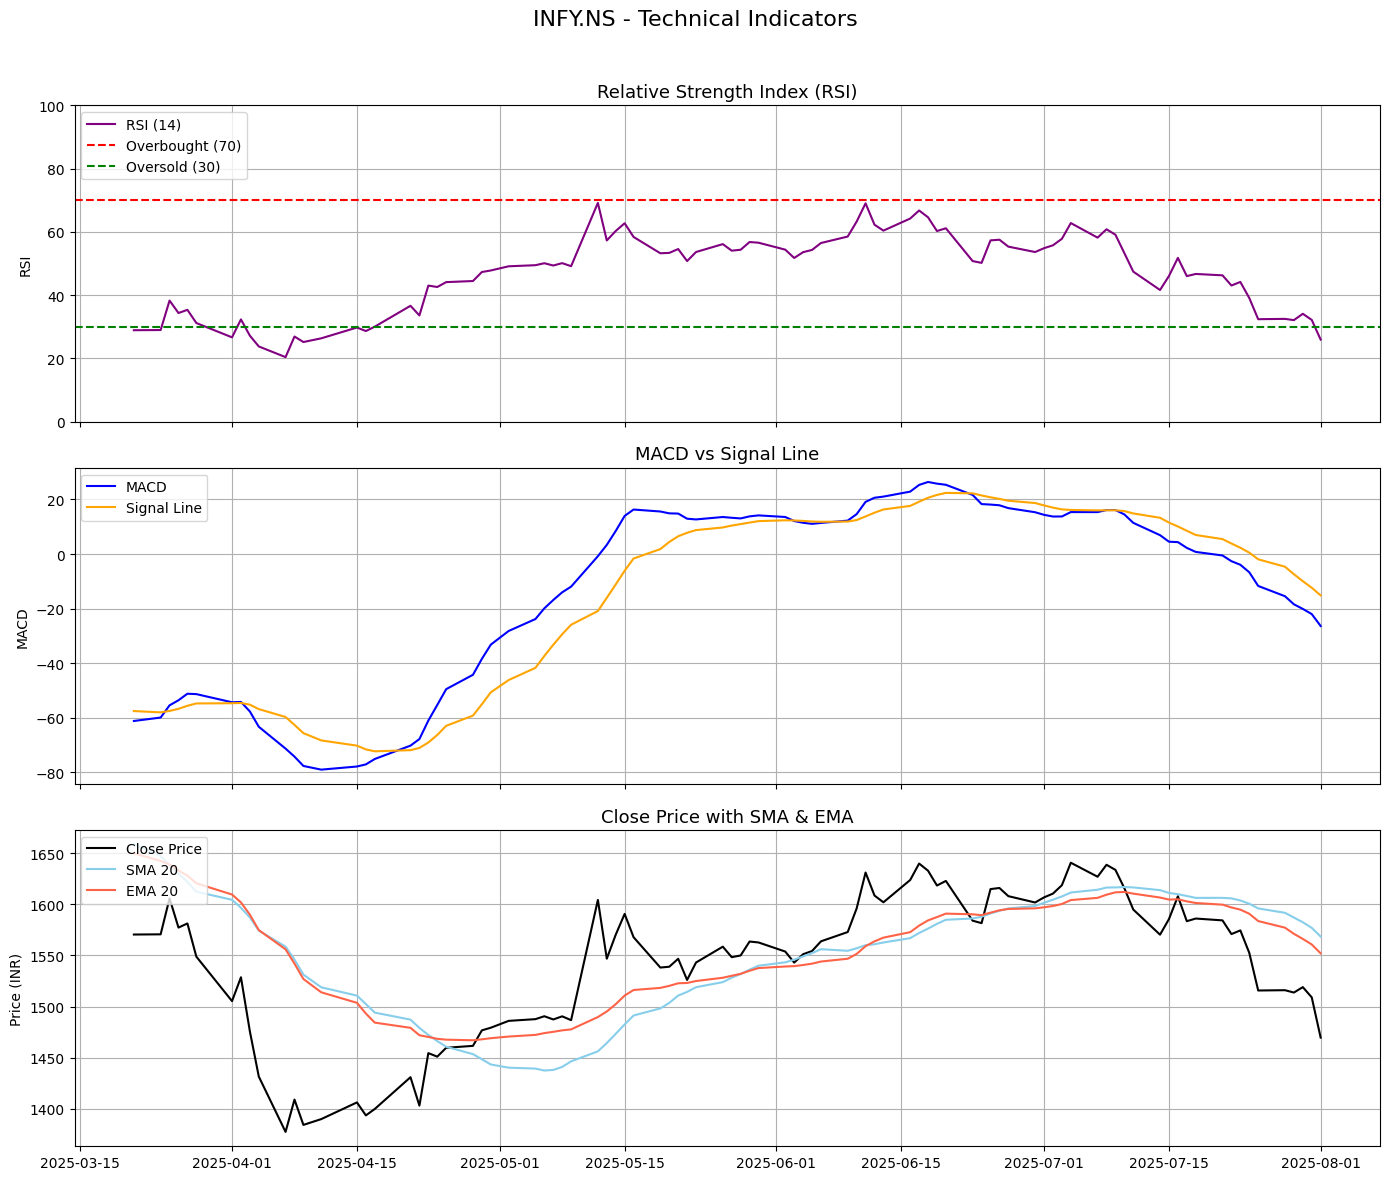

In [ ]:
symbol = 'INFY.NS' 
data = processed_infy 

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'{symbol} - Technical Indicators', fontsize=16)

# RSI
axes[0].plot(data.index, data['RSI'], label='RSI (14)', color='purple')
axes[0].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axes[0].set_ylim(0, 100)
axes[0].set_ylabel('RSI')
axes[0].set_title('Relative Strength Index (RSI)', fontsize=13)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# MACD
axes[1].plot(data.index, data['MACD'], label='MACD', color='blue')
axes[1].plot(data.index, data['MACD_Signal'], label='Signal Line', color='orange')
axes[1].set_ylabel('MACD')
axes[1].set_title('MACD vs Signal Line', fontsize=13)
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Close + SMA + EMA
axes[2].plot(data.index, data['Close'], label='Close Price', color='black')
axes[2].plot(data.index, data['SMA_20'], label='SMA 20', color='skyblue')
axes[2].plot(data.index, data['EMA_20'], label='EMA 20', color='tomato')
axes[2].set_ylabel('Price (INR)')
axes[2].set_title('Close Price with SMA & EMA', fontsize=13)
axes[2].legend(loc='upper left')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

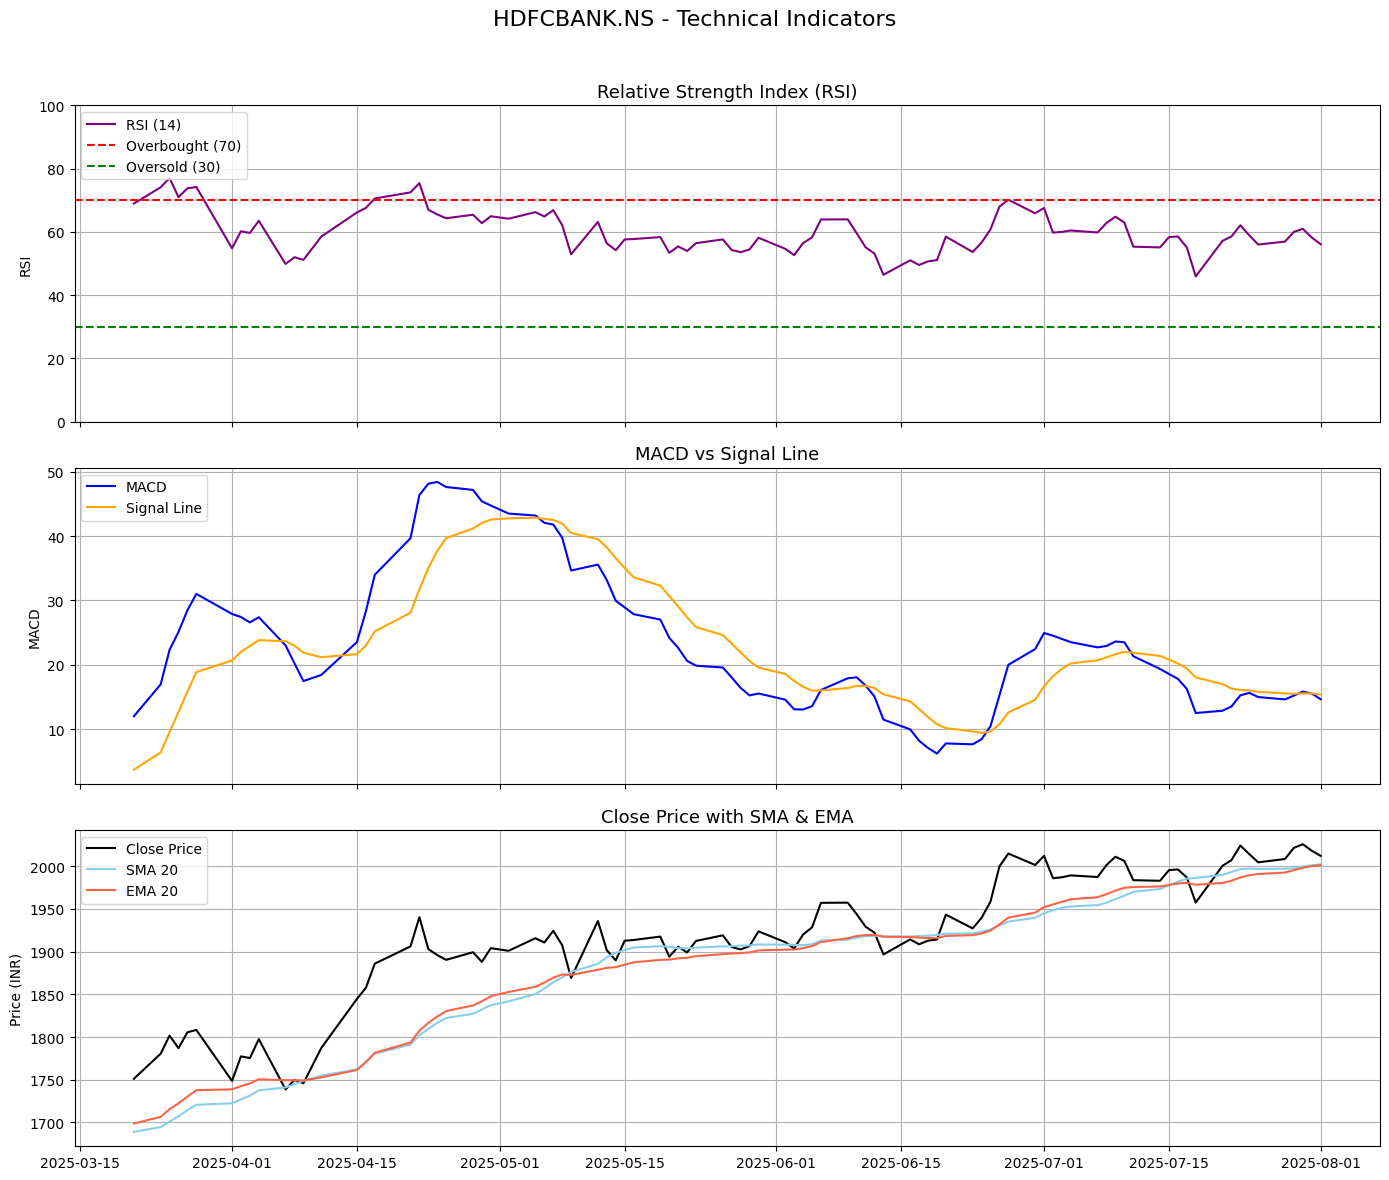

In [56]:
symbol = 'HDFCBANK.NS'
data = processed_hdfc  # Make sure this is defined from preprocessing

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'{symbol} - Technical Indicators', fontsize=16)

# RSI
axes[0].plot(data.index, data['RSI'], label='RSI (14)', color='purple')
axes[0].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axes[0].set_ylim(0, 100)
axes[0].set_ylabel('RSI')
axes[0].set_title('Relative Strength Index (RSI)', fontsize=13)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# MACD
axes[1].plot(data.index, data['MACD'], label='MACD', color='blue')
axes[1].plot(data.index, data['MACD_Signal'], label='Signal Line', color='orange')
axes[1].set_ylabel('MACD')
axes[1].set_title('MACD vs Signal Line', fontsize=13)
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Close + SMA + EMA
axes[2].plot(data.index, data['Close'], label='Close Price', color='black')
axes[2].plot(data.index, data['SMA_20'], label='SMA 20', color='skyblue')
axes[2].plot(data.index, data['EMA_20'], label='EMA 20', color='tomato')
axes[2].set_ylabel('Price (INR)')
axes[2].set_title('Close Price with SMA & EMA', fontsize=13)
axes[2].legend(loc='upper left')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

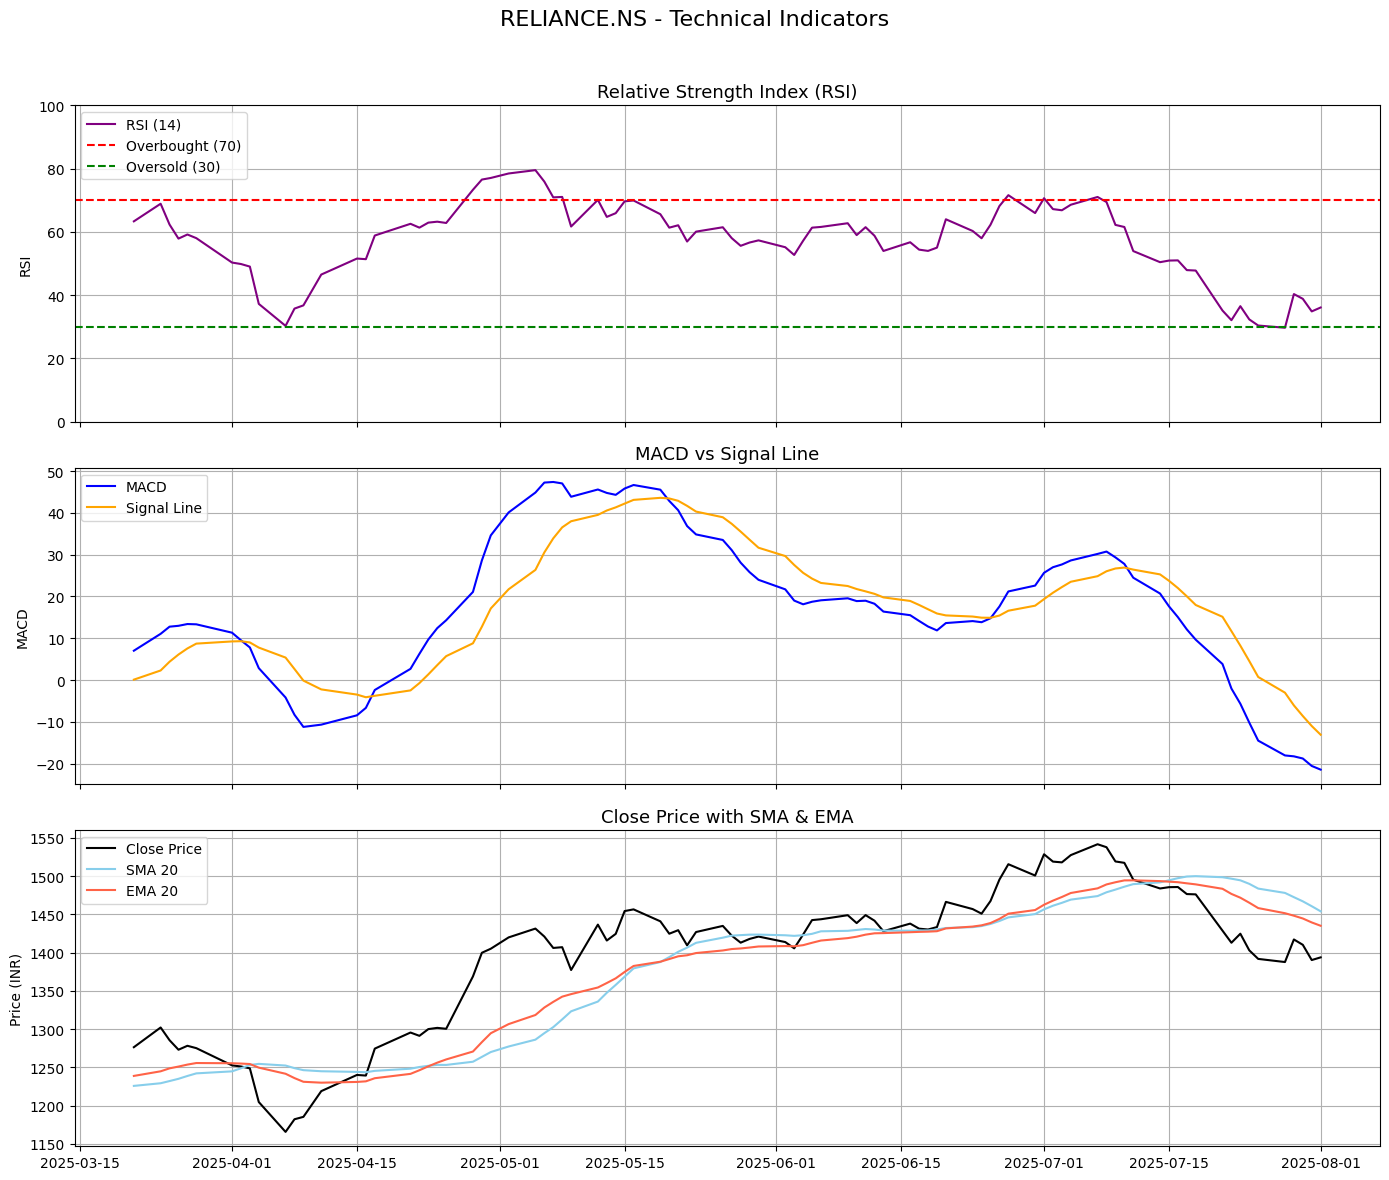

In [55]:
symbol = 'RELIANCE.NS'
data = processed_reliance  # Again, this should be defined already

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'{symbol} - Technical Indicators', fontsize=16)

# RSI
axes[0].plot(data.index, data['RSI'], label='RSI (14)', color='purple')
axes[0].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axes[0].set_ylim(0, 100)
axes[0].set_ylabel('RSI')
axes[0].set_title('Relative Strength Index (RSI)', fontsize=13)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# MACD
axes[1].plot(data.index, data['MACD'], label='MACD', color='blue')
axes[1].plot(data.index, data['MACD_Signal'], label='Signal Line', color='orange')
axes[1].set_ylabel('MACD')
axes[1].set_title('MACD vs Signal Line', fontsize=13)
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Close + SMA + EMA
axes[2].plot(data.index, data['Close'], label='Close Price', color='black')
axes[2].plot(data.index, data['SMA_20'], label='SMA 20', color='skyblue')
axes[2].plot(data.index, data['EMA_20'], label='EMA 20', color='tomato')
axes[2].set_ylabel('Price (INR)')
axes[2].set_title('Close Price with SMA & EMA', fontsize=13)
axes[2].legend(loc='upper left')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# MODEL TRAINING

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Select features ===
features = ["RSI", "MACD", "MACD_Signal", "SMA_20", "EMA_20", "Volatility"]

# === Step 2: Prepare train/test split ===
X = processed_infy[features]
y = processed_infy["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # No shuffle — respect time order
)

# === Step 3: Train the XGBoost model ===
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

# === Step 4: Make predictions ===
y_pred = model.predict(X_test)

# === Step 5: Evaluate ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("✅ Accuracy:", round(accuracy, 3))
print("✅ Precision:", round(precision, 3))

# === Optional: Visualize Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.grid(False)
plt.show()

In [14]:
# Step 3: Model Training and Prediction
def predict(train, test, predictors, model, threshold=0.5):
    """
    Train model and predict next-day movement with optimized threshold.
    """
    model.fit(train[predictors], train["Target"])
    preds_proba = model.predict_proba(test[predictors])[:, 1]
    preds = np.where(preds_proba >= threshold, 1, 0)
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined, preds_proba

def backtest(data, model, predictors, scale_pos_weight):
    """
    Backtest the model with train/validation/test split and threshold optimization.
    """
    # Calculate scale_pos_weight based on class imbalance
    neg, pos = np.bincount(data["Target"])
    scale_pos_weight_val = neg / pos if pos > 0 else 1.0
    
    # Split data: 70% train, 15% validation, 15% test
    train_data, temp_data = train_test_split(data, train_size=0.7, shuffle=False)
    val_data, test_data = train_test_split(temp_data, train_size=0.5, shuffle=False)
    
    # Define parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 300, 500],
        'min_child_weight': [10, 20, 50]  # XGBoost uses min_child_weight instead of min_samples_split
    }
    
    # Initialize and train model with GridSearchCV
    xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight_val, random_state=1)
    grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(train_data[predictors], train_data["Target"])
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {data.name}: {grid_search.best_params_}")
    
    # Optimize threshold on validation set
    _, val_probs = predict(val_data, val_data, predictors, best_model, threshold=0.5)
    best_threshold = 0.5
    best_score = 0.0
    for thresh in np.arange(0.5, 0.9, 0.1):
        preds = np.where(val_probs >= thresh, 1, 0)
        score = 0.5 * precision_score(val_data["Target"], preds) + 0.5 * accuracy_score(val_data["Target"], preds)
        if score > best_score:
            best_score = score
            best_threshold = thresh
    print(f"Optimal threshold for {data.name}: {best_threshold}")
    
    # Apply best model and threshold to test set
    predictions, _ = predict(test_data, test_data, predictors, best_model, threshold=best_threshold)
    return predictions

# Define predictors
predictors = ["Close", "Volume", "RSI_14", "MACD", "MACD_Signal", "SMA_10", "EMA_10", "Volume_Ratio", "Volatility"]

# Train and backtest for each stock
predictions = {}
for stock in stocks:
    if stock in processed_data and processed_data[stock] is not None:
        processed_data[stock].name = stock  # Set name for GridSearchCV and threshold optimization
        predictions[stock] = backtest(processed_data[stock], XGBClassifier(), predictors, scale_pos_weight=1.0)
    else:
        print(f"Skipping {stock} due to preprocessing failure.")

# Evaluate model performance
for stock in stocks:
    if stock in predictions and predictions[stock] is not None:
        print(f"\nModel Performance for {stock}:")
        print("Precision Score:", precision_score(predictions[stock]["Target"], predictions[stock]["Predictions"]))
        print("Accuracy Score:", accuracy_score(predictions[stock]["Target"], predictions[stock]["Predictions"]))
        print(predictions[stock]["Predictions"].value_counts())

Best parameters for RELIANCE.NS: {'min_child_weight': 10, 'n_estimators': 300}
Optimal threshold for RELIANCE.NS: 0.5
Best parameters for HDFCBANK.NS: {'min_child_weight': 50, 'n_estimators': 500}
Optimal threshold for HDFCBANK.NS: 0.6
Best parameters for INFY.NS: {'min_child_weight': 50, 'n_estimators': 500}
Optimal threshold for INFY.NS: 0.6

Model Performance for RELIANCE.NS:
Precision Score: 1.0
Accuracy Score: 1.0
Predictions
1    580
0    535
Name: count, dtype: int64

Model Performance for HDFCBANK.NS:
Precision Score: 0.918854415274463
Accuracy Score: 0.7919282511210762
Predictions
0    696
1    419
Name: count, dtype: int64

Model Performance for INFY.NS:
Precision Score: 0.9122340425531915
Accuracy Score: 0.7623318385650224
Predictions
0    739
1    376
Name: count, dtype: int64


In [2]:
# Step 4: Trading Strategy
def trading_strategy(predictions, df):
    """
    Implement a simple trading strategy based on predictions and compute cumulative returns.
    """
    # Create a copy and preserve the name attribute
    df = df.copy()
    df.name = df.name if hasattr(df, 'name') else None  # Safely check and set name
    if df.name is None:
        df.name = "Unknown"  # Default name if not set
    
    df["Predictions"] = predictions["Predictions"]
    df["Position"] = df["Predictions"].shift(1)  # Buy/sell on next day
    df["Returns"] = df["Close"].pct_change()
    df["Strategy_Returns"] = df["Returns"] * df["Position"]
    
    # Handle NaN and infinite values
    df["Strategy_Returns"] = df["Strategy_Returns"].fillna(0)
    df["Strategy_Returns"] = df["Strategy_Returns"].replace([np.inf, -np.inf], 0)
    
    # Compute cumulative returns
    df["Cumulative_Returns"] = (1 + df["Strategy_Returns"]).cumprod()
    
    # Compute buy-and-hold returns for benchmarking
    df["Buy_Hold_Returns"] = (1 + df["Returns"]).cumprod()
    
    # Handle initial NaN in cumulative returns
    df["Cumulative_Returns"] = df["Cumulative_Returns"].fillna(1.0)
    df["Buy_Hold_Returns"] = df["Buy_Hold_Returns"].fillna(1.0)
    
    # Debugging: Print summary of returns
    print(f"\nTrading Strategy Summary for {df.name}:")
    print("Number of NaN in Strategy Returns:", df["Strategy_Returns"].isna().sum())
    print("Number of NaN in Cumulative Returns:", df["Cumulative_Returns"].isna().sum())
    print("Cumulative Returns (last 5):")
    print(df["Cumulative_Returns"].tail())
    
    return df

# Apply trading strategy and visualize results
# Ensure stocks is defined here if running this section independently
stocks = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS"]  # Redefine if needed
for stock in stocks:
    if stock in processed_data and processed_data[stock] is not None:
        processed_data[stock].name = stock  # Set name for debugging
        df = trading_strategy(predictions[stock], processed_data[stock])
        
        # Plot cumulative returns with buy-and-hold benchmark
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(
                x=df.index,
                y=df["Cumulative_Returns"],
                name="Strategy Returns",
                line=dict(color="#00CC96"),
            )
        )
        fig.add_trace(
            go.Scatter(
                x=df.index,
                y=df["Buy_Hold_Returns"],
                name="Buy and Hold Returns",
                line=dict(color="#EF553B", dash="dash"),
            )
        )
        fig.update_layout(
            title=f"{stock}: Cumulative Returns of Trading Strategy vs. Buy and Hold",
            yaxis_title="Cumulative Returns",
            template="plotly_dark",
            showlegend=True,
            height=600,
            xaxis=dict(rangeslider=dict(visible=False))  # Disable rangeslider for simplicity
        )
        fig.update_xaxes(title_text="Date")
        fig.write_html(f"{stock}_strategy_returns.html")
        fig.show()
    else:
        print(f"Skipping trading strategy visualization for {stock} due to data issues.")

NameError: name 'processed_data' is not defined